In [ ]:
import pandas as pd
from collections import Counter
import json
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

df = pd.read_parquet("los_dataset_24h.parquet")

print(df.shape)
print(df.columns)

(424803, 17)
Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'race', 'los_hours',
       'gender', 'anchor_age', 'curr_service', 'hcpcs_cd_list',
       'diagnoses_icd_code_list', 'procedures_icd_code_list', 'drg_code',
       'drg_severity', 'drg_mortality', 'medication_list', 'order_type_list'],
      dtype='object')


In [ ]:
def build_label_encoder(series):
    classes = sorted(series.unique())
    stoi = {c: i for i, c in enumerate(classes)}
    return stoi


def build_vocab_from_list_column(df, col, min_freq=1, add_unk=True):
    counter = Counter()
    for lst in df[col]:
        counter.update(lst)

    stoi = {}
    idx = 0
    if add_unk:
        stoi["<UNK>"] = idx
        idx += 1

    for token, freq in counter.items():
        if freq >= min_freq:
            if token not in stoi:
                stoi[token] = idx
                idx += 1

    return stoi

In [3]:
# Encoders for gender, race, curr_service, drg_code
gender_stoi = build_label_encoder(df["gender"])
race_stoi = build_label_encoder(df["race"])
service_stoi = build_label_encoder(df["curr_service"])

# drg_code is already an int, but treated as a "category" and re-mapped to an index
drg_code_stoi = build_label_encoder(df["drg_code"].astype(int))

print("num_genders:", len(gender_stoi))
print("num_races:", len(race_stoi))
print("num_services:", len(service_stoi))
print("num_drg_codes:", len(drg_code_stoi))

num_genders: 2
num_races: 33
num_services: 21
num_drg_codes: 301


In [4]:
list_cols = [
    "diagnoses_icd_code_list",
    "procedures_icd_code_list",
    "hcpcs_cd_list",
    "medication_list",
    "order_type_list",
]

diag_stoi = build_vocab_from_list_column(df, "diagnoses_icd_code_list", min_freq=1)
proc_stoi = build_vocab_from_list_column(df, "procedures_icd_code_list", min_freq=1)
hcpcs_stoi = build_vocab_from_list_column(df, "hcpcs_cd_list", min_freq=1)
med_stoi = build_vocab_from_list_column(df, "medication_list", min_freq=1)
order_stoi = build_vocab_from_list_column(df, "order_type_list", min_freq=1)

print("diag vocab size:", len(diag_stoi))
print("proc vocab size:", len(proc_stoi))
print("hcpcs vocab size:", len(hcpcs_stoi))
print("med vocab size:", len(med_stoi))
print("order vocab size:", len(order_stoi))

diag vocab size: 27701
proc vocab size: 12184
hcpcs vocab size: 1925
med vocab size: 3358
order vocab size: 17


In [5]:
# Combine proc_stoi and hcpcs_stoi into a single unified vocab
proc_all_stoi = {}
idx = 0

# Only one UNK
proc_all_stoi["<UNK>"] = idx
idx += 1

# Procedures first
for k in proc_stoi.keys():
    if k == "<UNK>":
        continue
    proc_all_stoi["PROC_" + k] = idx
    idx += 1

# HCPCS next
for k in hcpcs_stoi.keys():
    if k == "<UNK>":
        continue
    key = "HCPCS_" + k
    if key not in proc_all_stoi:
        proc_all_stoi[key] = idx
        idx += 1

print("combined proc vocab size:", len(proc_all_stoi))

combined proc vocab size: 14108


In [6]:
UNK_DIAG = diag_stoi["<UNK>"]
UNK_PROC = proc_all_stoi["<UNK>"]
UNK_MED = med_stoi["<UNK>"]
UNK_ORDER = order_stoi["<UNK>"]

def map_list_to_ids(lst, stoi, unk_token="<UNK>"):
    unk_idx = stoi.get(unk_token, None)
    out = []
    for x in lst:
        idx = stoi.get(x)
        if idx is None:
            if unk_idx is not None:
                out.append(unk_idx)
        else:
            out.append(idx)
    return out

# Diagnosis codes
df["diag_ids"] = df["diagnoses_icd_code_list"].apply(
    lambda lst: map_list_to_ids(lst, diag_stoi)
)

# Combined procedure + hcpcs ids
def build_proc_ids(row):
    ids = []
    for code in row["procedures_icd_code_list"]:
        tok = "PROC_" + code
        ids.append(proc_all_stoi.get(tok, UNK_PROC))
    for code in row["hcpcs_cd_list"]:
        tok = "HCPCS_" + code
        ids.append(proc_all_stoi.get(tok, UNK_PROC))
    return ids

df["proc_ids"] = df.apply(build_proc_ids, axis=1)

# Medication
df["med_ids"] = df["medication_list"].apply(
    lambda lst: map_list_to_ids(lst, med_stoi)
)

# Order type
df["order_ids"] = df["order_type_list"].apply(
    lambda lst: map_list_to_ids(lst, order_stoi)
)

# Single categorical -> id
df["gender_id"] = df["gender"].map(gender_stoi)
df["race_id"] = df["race"].map(race_stoi)
df["service_id"] = df["curr_service"].map(service_stoi)
df["drg_code_id"] = df["drg_code"].astype(int).map(drg_code_stoi)

In [ ]:
def summarize_list(lst, max_len=10):
    """
    Summarizes a list by truncating if it's too long, showing only the beginning.
    """
    if lst is None:
        return None
    if len(lst) <= max_len:
        return lst
    return lst[:max_len] + ["...(+{} more)".format(len(lst) - max_len)]


# Print 3 samples
cols_to_show = [
    "gender", "race", "curr_service", "drg_code",
    "gender_id", "race_id", "service_id", "drg_code_id",
    "diagnoses_icd_code_list", "diag_ids",
    "procedures_icd_code_list", "hcpcs_cd_list", "proc_ids",
    "medication_list", "med_ids",
    "order_type_list", "order_ids",
]

print("\n================ SAMPLE DATA (after encoding) ================\n")

for i in range(3):
    row = df.iloc[i]
    print(f"--- Row {i} ---")

    for c in cols_to_show:
        val = row[c]

        # Summarize list
        if isinstance(val, list):
            val = summarize_list(val)

        print(f"{c:25} : {val}")

    print("\n")


================ SAMPLE DATA (after encoding) ================

--- Row 0 ---
gender                    : F
race                      : WHITE
curr_service              : MED
drg_code                  : 279
gender_id                 : 0
race_id                   : 28
service_id                : 7
drg_code_id               : 135
diagnoses_icd_code_list   : ['07071' '78959' '2875' '2761' '496' '5715' 'V08' '3051']
diag_ids                  : [1, 2, 3, 4, 5, 6, 7, 8]
procedures_icd_code_list  : ['5491']
hcpcs_cd_list             : []
proc_ids                  : [1]
medication_list           : ['Raltegravir' 'Rifaximin' 'Sodium Chloride 0.9%  Flush'
 'Calcium Carbonate' 'Rifaximin' 'Raltegravir'
 'Emtricitabine-Tenofovir (Truvada)' 'Sulfameth/Trimethoprim DS'
 'Furosemide' 'Tiotropium Bromide' 'Albuterol Inhaler' 'Lactulose'
 'Heparin' 'Sodium Chloride 0.9%  Flush' 'Acetaminophen' 'Heparin'
 'Lactulose' 'Albumin 25% (12.5g / 50mL)' 'Sodium Chloride 0.9%  Flush'
 'Albumin 25% (12.5g / 50mL)

In [8]:
class LOSDataset(Dataset):
    def __init__(self, df, use_log_target=True):
        self.df = df.reset_index(drop=True)
        self.use_log_target = use_log_target

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        sample = {
            # tabular
            "age": float(row["anchor_age"]),
            "gender_id": int(row["gender_id"]),
            "race_id": int(row["race_id"]),
            "service_id": int(row["service_id"]),
            "drg_code_id": int(row["drg_code_id"]),
            "drg_severity": float(row["drg_severity"]),
            "drg_mortality": float(row["drg_mortality"]),

            # List-type IDs
            "diag_ids": row["diag_ids"],
            "proc_ids": row["proc_ids"],
            "med_ids": row["med_ids"],
            "order_ids": row["order_ids"],
        }

        # target
        los = float(row["los_hours"])
        if self.use_log_target:
            sample["target"] = np.log1p(los)
        else:
            sample["target"] = los

        return sample

In [9]:
def los_collate_fn(batch):
    """
    batch: list of samples(dict)
    For EmbeddingBag, creates and returns:
    - codes: 1D LongTensor
    - offsets: LongTensor (length B+1, based on include_last_offset=True)
    for each list-type feature.
    """
    B = len(batch)

    # ----- Stack Tabular Features -----
    age = torch.tensor([b["age"] for b in batch], dtype=torch.float32)
    gender_id = torch.tensor([b["gender_id"] for b in batch], dtype=torch.long)
    race_id = torch.tensor([b["race_id"] for b in batch], dtype=torch.long)
    service_id = torch.tensor([b["service_id"] for b in batch], dtype=torch.long)
    drg_code_id = torch.tensor([b["drg_code_id"] for b in batch], dtype=torch.long)
    drg_severity = torch.tensor([b["drg_severity"] for b in batch], dtype=torch.float32)
    drg_mortality = torch.tensor([b["drg_mortality"] for b in batch], dtype=torch.float32)

    target = torch.tensor([b["target"] for b in batch], dtype=torch.float32)

    # ----- List-type Features: diag / proc / med / order -----
    def build_bag_inputs(key):
        codes_all = []
        offsets = [0]
        for b in batch:
            ids = b[key]
            codes_all.extend(ids)
            offsets.append(len(codes_all))
        if len(codes_all) == 0:
            # Handle cases where the list is empty for all admissions
            codes_tensor = torch.empty(0, dtype=torch.long)
        else:
            codes_tensor = torch.tensor(codes_all, dtype=torch.long)
        offsets_tensor = torch.tensor(offsets, dtype=torch.long)
        return codes_tensor, offsets_tensor

    diag_codes, diag_offsets = build_bag_inputs("diag_ids")
    proc_codes, proc_offsets = build_bag_inputs("proc_ids")
    med_codes, med_offsets = build_bag_inputs("med_ids")
    order_codes, order_offsets = build_bag_inputs("order_ids")

    batch_out = {
        "age": age,
        "gender_id": gender_id,
        "race_id": race_id,
        "service_id": service_id,
        "drg_code_id": drg_code_id,
        "drg_severity": drg_severity,
        "drg_mortality": drg_mortality,
        "diag_codes": diag_codes,
        "diag_offsets": diag_offsets,
        "proc_codes": proc_codes,
        "proc_offsets": proc_offsets,
        "med_codes": med_codes,
        "med_offsets": med_offsets,
        "order_codes": order_codes,
        "order_offsets": order_offsets,
        "target": target,
    }

    return batch_out

In [10]:
from torch.utils.data import random_split, DataLoader
import torch

# Create Dataset
dataset = LOSDataset(df, use_log_target=True)

n_total = len(dataset)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)
n_test = n_total - n_train - n_val   # remaining

g = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test], generator=g)

train_loader = DataLoader(
    train_ds,
    batch_size=256,
    shuffle=True,
    collate_fn=los_collate_fn,
)

val_loader = DataLoader(
    val_ds,
    batch_size=256,
    shuffle=False,
    collate_fn=los_collate_fn,
)

test_loader = DataLoader(
    test_ds,
    batch_size=256,
    shuffle=False,
    collate_fn=los_collate_fn,
)

print(f"#train: {len(train_ds)}, #val: {len(val_ds)}, #test: {len(test_ds)}")

#train: 297362, #val: 63720, #test: 63721


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass


@dataclass
class ModelConfig:
    # ----- Tabular categorical vocab sizes -----
    num_genders: int          # e.g. {"M", "F"} -> 2
    num_races: int            # unique race categories
    num_services: int         # curr_service (MED, ORTHO, ...)
    num_drg_codes: int        # drg_code vocab size

    # ----- Code vocab sizes -----
    diag_vocab_size: int      # diagnoses_icd_code_list vocab
    proc_vocab_size: int      # procedures_icd_code_list + hcpcs_cd_list integrated vocab
    med_vocab_size: int       # medication_list vocab
    order_vocab_size: int     # order_type_list vocab

    # ----- Embedding dimensions -----
    emb_dim_gender: int = 4
    emb_dim_race: int = 8
    emb_dim_service: int = 8
    emb_dim_drg: int = 16

    emb_dim_diag: int = 32
    emb_dim_proc: int = 32
    emb_dim_med: int = 32
    emb_dim_order: int = 16

    # ----- Hidden dimension for the single MLP -----
    hidden_dim: int = 128 # This will be the hidden dimension for the combined MLP
    dropout: float = 0.2


class MultiModalLOSModel(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.cfg = cfg

        # ------------- Embeddings for all categorical and list features -------------
        self.gender_emb = nn.Embedding(cfg.num_genders, cfg.emb_dim_gender)
        self.race_emb = nn.Embedding(cfg.num_races, cfg.emb_dim_race)
        self.service_emb = nn.Embedding(cfg.num_services, cfg.emb_dim_service)
        self.drg_emb = nn.Embedding(cfg.num_drg_codes, cfg.emb_dim_drg)

        self.diag_emb = nn.EmbeddingBag(
            cfg.diag_vocab_size, cfg.emb_dim_diag,
            mode="mean", include_last_offset=True
        )
        self.proc_emb = nn.EmbeddingBag(
            cfg.proc_vocab_size, cfg.emb_dim_proc,
            mode="mean", include_last_offset=True
        )
        self.med_emb = nn.EmbeddingBag(
            cfg.med_vocab_size, cfg.emb_dim_med,
            mode="mean", include_last_offset=True
        )
        self.order_emb = nn.EmbeddingBag(
            cfg.order_vocab_size, cfg.emb_dim_order,
            mode="mean", include_last_offset=True
        )

        # Calculate total input dimension for the single MLP
        total_in_dim = (
            3 # for age, drg_severity, drg_mortality
            + cfg.emb_dim_gender
            + cfg.emb_dim_race
            + cfg.emb_dim_service
            + cfg.emb_dim_drg
            + cfg.emb_dim_diag
            + cfg.emb_dim_proc
            + cfg.emb_dim_med
            + cfg.emb_dim_order
        )

        # Single MLP for all combined features
        self.main_mlp = nn.Sequential(
            nn.Linear(total_in_dim, cfg.hidden_dim),
            nn.ReLU(),
            nn.Dropout(cfg.dropout),
            nn.Linear(cfg.hidden_dim, cfg.hidden_dim),
            nn.ReLU(),
            nn.Dropout(cfg.dropout),
        )

        # Final regression output layer (LOS prediction)
        self.out = nn.Linear(cfg.hidden_dim, 1)


    def forward(
        self,
        # ----- Tabular -----
        age,               # (B,) float tensor (anchor_age or normalized)
        gender_idx,        # (B,) long tensor
        race_idx,          # (B,) long tensor
        service_idx,       # (B,) long tensor (curr_service)
        drg_code_idx,      # (B,) long tensor
        drg_severity,      # (B,) float or long (normalize to float first)
        drg_mortality,     # (B,) float or long

        # ----- Diagnoses (EmbeddingBag) -----
        diag_codes,        # (N_diag_codes,) long tensor (flattened)
        diag_offsets,      # (B+1,) long tensor, offsets for EmbeddingBag

        # ----- Procedures (EmbeddingBag) -----
        proc_codes,        # (N_proc_codes,) long tensor
        proc_offsets,      # (B+1,) long tensor

        # ----- Medications (EmbeddingBag) -----
        med_codes,         # (N_med_codes,) long tensor
        med_offsets,       # (B+1,) long tensor

        # ----- Order types (EmbeddingBag) -----
        order_codes,       # (N_order_codes,) long tensor
        order_offsets,     # (B+1,) long tensor
    ):
        # Embeddings for categorical features
        g_emb = self.gender_emb(gender_idx)   # (B, emb_dim_gender)
        r_emb = self.race_emb(race_idx)       # (B, emb_dim_race)
        s_emb = self.service_emb(service_idx) # (B, emb_dim_service)
        d_emb = self.drg_emb(drg_code_idx)    # (B, emb_dim_drg)

        # EmbeddingBag for list features
        diag_bag = self.diag_emb(diag_codes, diag_offsets)  # (B, emb_dim_diag)
        proc_bag = self.proc_emb(proc_codes, proc_offsets)  # (B, emb_dim_proc)
        med_bag = self.med_emb(med_codes, med_offsets)      # (B, emb_dim_med)
        order_bag = self.order_emb(order_codes, order_offsets) # (B, emb_dim_order)

        # Continuous features (unsqueeze for concatenation)
        age = age.float().unsqueeze(-1)                 # (B, 1)
        sev = drg_severity.float().unsqueeze(-1)        # (B, 1)
        mort = drg_mortality.float().unsqueeze(-1)      # (B, 1)

        # Concatenate all features into a single tensor
        all_features = torch.cat(
            [
                age, sev, mort,
                g_emb, r_emb, s_emb, d_emb,
                diag_bag, proc_bag, med_bag, order_bag
            ],
            dim=-1
        )

        # Pass the combined features through the main MLP
        h = self.main_mlp(all_features)
        out = self.out(h).squeeze(-1)  # (B,)

        return out

In [ ]:
# 1. Model / Configuration Setup

cfg = ModelConfig(
    num_genders=len(gender_stoi),
    num_races=len(race_stoi),
    num_services=len(service_stoi),
    num_drg_codes=len(drg_code_stoi),
    diag_vocab_size=len(diag_stoi),
    proc_vocab_size=len(proc_all_stoi),
    med_vocab_size=len(med_stoi),
    order_vocab_size=len(order_stoi),
    hidden_dim=128,
    dropout=0.2
)

model = MultiModalLOSModel(cfg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()  # MSE based on log(1+LOS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

NUM_EPOCHS = 20

best_val_loss = float("inf")
best_model_path = "los_multibranch_best.pt"
print("Using device:", device)


# 2. Training Loop
for epoch in range(1, NUM_EPOCHS + 1):
    # ---------- Train ----------
    model.train()
    train_loss_sum = 0.0
    train_count = 0

    print(f"\n========== Epoch {epoch}/{NUM_EPOCHS} ==========")

    for batch_idx, batch in enumerate(train_loader):
        # Move tensors to device
        batch = {k: (v.to(device) if torch.is_tensor(v) else v)
                 for k, v in batch.items()}

        optimizer.zero_grad()

        y_pred = model(
            age=batch["age"],
            gender_idx=batch["gender_id"],
            race_idx=batch["race_id"],
            service_idx=batch["service_id"],
            drg_code_idx=batch["drg_code_id"],
            drg_severity=batch["drg_severity"],
            drg_mortality=batch["drg_mortality"],
            diag_codes=batch["diag_codes"],
            diag_offsets=batch["diag_offsets"],
            proc_codes=batch["proc_codes"],
            proc_offsets=batch["proc_offsets"],
            med_codes=batch["med_codes"],
            med_offsets=batch["med_offsets"],
            order_codes=batch["order_codes"],
            order_offsets=batch["order_offsets"],
        )

        y_true = batch["target"]  # log(1+LOS)
        loss = criterion(y_pred, y_true)

        loss.backward()
        optimizer.step()

        bs = y_true.size(0)
        train_loss_sum += loss.item() * bs
        train_count += bs

        if batch_idx % 100 == 0:
            avg_loss = train_loss_sum / train_count
            print(f"  [Epoch {epoch} | Step {batch_idx}/{len(train_loader)}] "
                  f"AvgTrainLoss={avg_loss:.4f}")

    train_loss = train_loss_sum / train_count

    # ---------- Validation ----------
    model.eval()
    val_loss_sum = 0.0
    val_count = 0
    val_mae_hours_sum = 0.0  # MAE based on actual LOS(hours)

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: (v.to(device) if torch.is_tensor(v) else v)
                     for k, v in batch.items()}

            y_pred = model(
                age=batch["age"],
                gender_idx=batch["gender_id"],
                race_idx=batch["race_id"],
                service_idx=batch["service_id"],
                drg_code_idx=batch["drg_code_id"],
                drg_severity=batch["drg_severity"],
                drg_mortality=batch["drg_mortality"],
                diag_codes=batch["diag_codes"],
                diag_offsets=batch["diag_offsets"],
                proc_codes=batch["proc_codes"],
                proc_offsets=batch["proc_offsets"],
                med_codes=batch["med_codes"],
                med_offsets=batch["med_offsets"],
                order_codes=batch["order_codes"],
                order_offsets=batch["order_offsets"],
            )

            y_true = batch["target"]

            loss = criterion(y_pred, y_true)

            bs = y_true.size(0)
            val_loss_sum += loss.item() * bs
            val_count += bs

            # Convert log(1+LOS) -> actual LOS(hours) for MAE calculation
            y_true_hours = torch.expm1(y_true)
            y_pred_hours = torch.expm1(y_pred)

            mae_hours = torch.abs(y_pred_hours - y_true_hours).sum().item()
            val_mae_hours_sum += mae_hours

    val_loss = val_loss_sum / val_count
    val_mae_hours = val_mae_hours_sum / val_count

    print(f"[Epoch {epoch:03d}] "\
          f"train_loss(log-MSE)={train_loss:.4f} | "\
          f"val_loss(log-MSE)={val_loss:.4f} | "\
          f"val_MAE(hours)={val_mae_hours:.2f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  ↳ Best model updated, saved to {best_model_path}")

print("Training finished. Best val_loss:", best_val_loss)

Using device: cuda

========== Epoch 1/20 ==========
  [Epoch 1 | Step 0/1162] AvgTrainLoss=36.3356
  [Epoch 1 | Step 100/1162] AvgTrainLoss=3.0450
  [Epoch 1 | Step 200/1162] AvgTrainLoss=1.9264
  [Epoch 1 | Step 300/1162] AvgTrainLoss=1.5110
  [Epoch 1 | Step 400/1162] AvgTrainLoss=1.2952
  [Epoch 1 | Step 500/1162] AvgTrainLoss=1.1597
  [Epoch 1 | Step 600/1162] AvgTrainLoss=1.0666
  [Epoch 1 | Step 700/1162] AvgTrainLoss=0.9969
  [Epoch 1 | Step 800/1162] AvgTrainLoss=0.9423
  [Epoch 1 | Step 900/1162] AvgTrainLoss=0.8989
  [Epoch 1 | Step 1000/1162] AvgTrainLoss=0.8637
  [Epoch 1 | Step 1100/1162] AvgTrainLoss=0.8330
[Epoch 001] train_loss(log-MSE)=0.8169 | val_loss(log-MSE)=0.3788 | val_MAE(hours)=70.34
  ↳ Best model updated, saved to los_multibranch_best.pt

========== Epoch 2/20 ==========
  [Epoch 2 | Step 0/1162] AvgTrainLoss=0.5073
  [Epoch 2 | Step 100/1162] AvgTrainLoss=0.5092
  [Epoch 2 | Step 200/1162] AvgTrainLoss=0.5009
  [Epoch 2 | Step 300/1162] AvgTrainLoss=0.4953


In [ ]:
# 3. Calculate MAE (hours) on the Test set

best_model = MultiModalLOSModel(cfg).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

test_abs_error_sum = 0.0
test_count = 0

with torch.no_grad():
    for batch in test_loader:
        batch = {k: (v.to(device) if torch.is_tensor(v) else v)
                 for k, v in batch.items()}

        y_pred = best_model(
            age=batch["age"],
            gender_idx=batch["gender_id"],
            race_idx=batch["race_id"],
            service_idx=batch["service_id"],
            drg_code_idx=batch["drg_code_id"],
            drg_severity=batch["drg_severity"],
            drg_mortality=batch["drg_mortality"],
            diag_codes=batch["diag_codes"],
            diag_offsets=batch["diag_offsets"],
            proc_codes=batch["proc_codes"],
            proc_offsets=batch["proc_offsets"],
            med_codes=batch["med_codes"],
            med_offsets=batch["med_offsets"],
            order_codes=batch["order_codes"],
            order_offsets=batch["order_offsets"],
        )

        y_true = batch["target"]  # log(1+LOS)

        # Convert log(1+LOS) -> actual hours
        y_true_hours = torch.expm1(y_true)
        y_pred_hours = torch.expm1(y_pred)

        abs_err = torch.abs(y_pred_hours - y_true_hours)
        test_abs_error_sum += abs_err.sum().item()
        test_count += y_true.size(0)

test_mae_hours = test_abs_error_sum / test_count

print(f"\n===== Test set MAE =====")
print(f"Test MAE (hours): {test_mae_hours:.2f}")
print(f"Test MAE (days) : {test_mae_hours / 24:.2f}")


===== Test set MAE =====
Test MAE (hours): 59.12
Test MAE (days) : 2.46


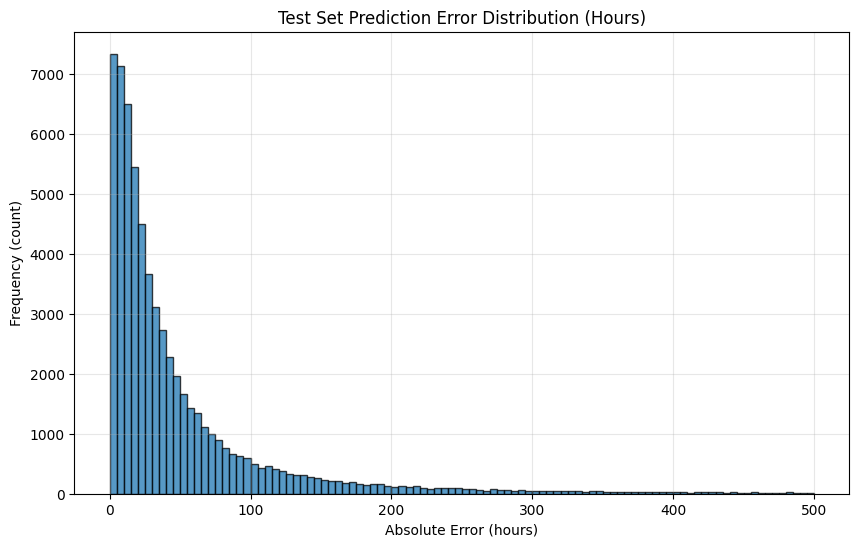

In [ ]:
import matplotlib.pyplot as plt

all_abs_errors = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: (v.to(device) if torch.is_tensor(v) else v)
                 for k, v in batch.items()}

        y_pred = best_model(
            age=batch["age"],
            gender_idx=batch["gender_id"],
            race_idx=batch["race_id"],
            service_idx=batch["service_id"],
            drg_code_idx=batch["drg_code_id"],
            drg_severity=batch["drg_severity"],
            drg_mortality=batch["drg_mortality"],
            diag_codes=batch["diag_codes"],
            diag_offsets=batch["diag_offsets"],
            proc_codes=batch["proc_codes"],
            proc_offsets=batch["proc_offsets"],
            med_codes=batch["med_codes"],
            med_offsets=batch["med_offsets"],
            order_codes=batch["order_codes"],
            order_offsets=batch["order_offsets"],
        )

        y_true = batch["target"]  # log(1+LOS)

        y_true_hours = torch.expm1(y_true)
        y_pred_hours = torch.expm1(y_pred)

        abs_err = torch.abs(y_pred_hours - y_true_hours)

        all_abs_errors.extend(abs_err.cpu().numpy())


plt.figure(figsize=(10, 6))
plt.hist(
    all_abs_errors,
    bins=100,              # Number of bins
    range=(0, 500),        # x-axis range (0~500 hours)
    edgecolor='black',
    alpha=0.75
)

plt.title("Test Set Prediction Error Distribution (Hours)")
plt.xlabel("Absolute Error (hours)")
plt.ylabel("Frequency (count)")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Print True vs Predicted values

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

print("\n====== Sample Predictions (True vs Predicted LOS) ======\n")

num_show = 20  
shown = 0

with torch.no_grad():
    for batch in val_loader:
        batch = {k: (v.to(device) if torch.is_tensor(v) else v)
                 for k, v in batch.items()}

        y_pred = model(
            age=batch["age"],
            gender_idx=batch["gender_id"],
            race_idx=batch["race_id"],
            service_idx=batch["service_id"],
            drg_code_idx=batch["drg_code_id"],
            drg_severity=batch["drg_severity"],
            drg_mortality=batch["drg_mortality"],
            diag_codes=batch["diag_codes"],
            diag_offsets=batch["diag_offsets"],
            proc_codes=batch["proc_codes"],
            proc_offsets=batch["proc_offsets"],
            med_codes=batch["med_codes"],
            med_offsets=batch["med_offsets"],
            order_codes=batch["order_codes"],
            order_offsets=batch["order_offsets"],
        )

        y_true = batch["target"]

        # Convert log-scale → hours
        y_true_hours = torch.expm1(y_true).cpu().numpy()
        y_pred_hours = torch.expm1(y_pred).cpu().numpy()

        for t, p in zip(y_true_hours, y_pred_hours):
            print(f"True LOS: {t:.2f} hours | Predicted: {p:.2f} hours | Error: {abs(t - p):.2f}")
            shown += 1
            if shown >= num_show:
                break

        if shown >= num_show:
                break


====== Sample Predictions (True vs Predicted LOS) ======

True LOS: 44.72 hours | Predicted: 61.32 hours | Error: 16.60
True LOS: 55.63 hours | Predicted: 125.80 hours | Error: 70.16
True LOS: 90.42 hours | Predicted: 150.41 hours | Error: 60.00
True LOS: 24.08 hours | Predicted: 81.25 hours | Error: 57.17
True LOS: 106.88 hours | Predicted: 55.25 hours | Error: 51.63
True LOS: 247.07 hours | Predicted: 94.80 hours | Error: 152.26
True LOS: 261.08 hours | Predicted: 131.88 hours | Error: 129.21
True LOS: 35.00 hours | Predicted: 50.31 hours | Error: 15.31
True LOS: 63.13 hours | Predicted: 57.03 hours | Error: 6.10
True LOS: 102.85 hours | Predicted: 149.22 hours | Error: 46.37
True LOS: 80.08 hours | Predicted: 83.33 hours | Error: 3.25
True LOS: 44.72 hours | Predicted: 71.86 hours | Error: 27.14
True LOS: 255.52 hours | Predicted: 102.79 hours | Error: 152.73
True LOS: 45.53 hours | Predicted: 42.65 hours | Error: 2.88
True LOS: 840.62 hours | Predicted: 462.14 hours | Error: 378.4

In [16]:
import numpy as np
import torch

# Load the best weighted model (re-initializing it in case the kernel state was lost)
best_model = MultiModalLOSModel(cfg).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

all_true_los_hours = []
all_pred_los_hours = []

# Ensure the model is in evaluation mode
best_model.eval()

with torch.no_grad():
    for batch in test_loader:
        batch = {k: (v.to(device) if torch.is_tensor(v) else v)
                 for k, v in batch.items()}

        y_pred_log = best_model(
            age=batch["age"],
            gender_idx=batch["gender_id"],
            race_idx=batch["race_id"],
            service_idx=batch["service_id"],
            drg_code_idx=batch["drg_code_id"],
            drg_severity=batch["drg_severity"],
            drg_mortality=batch["drg_mortality"],
            diag_codes=batch["diag_codes"],
            diag_offsets=batch["diag_offsets"],
            proc_codes=batch["proc_codes"],
            proc_offsets=batch["proc_offsets"],
            med_codes=batch["med_codes"],
            med_offsets=batch["med_offsets"],
            order_codes=batch["order_codes"],
            order_offsets=batch["order_offsets"],
        )

        y_true_log = batch["target"]

        # Convert log(1+LOS) to actual LOS hours
        y_true_hours = torch.expm1(y_true_log).cpu().numpy()
        y_pred_hours = torch.expm1(y_pred_log).cpu().numpy()

        all_true_los_hours.extend(y_true_hours)
        all_pred_los_hours.extend(y_pred_hours)

# Convert lists to numpy arrays
all_true_los_hours = np.array(all_true_los_hours)
all_pred_los_hours = np.array(all_pred_los_hours)

# Define LOS ranges and calculate MAE for each
los_ranges = [
    (0, 200, "0-200 hours"),
    (200, 400, "200-400 hours"),
    (400, np.inf, ">400 hours"),
]

print("\n===== MAE by LOS Range (Test Set) ====")
for lower_bound, upper_bound, label in los_ranges:
    if upper_bound == np.inf:
        mask = (all_true_los_hours >= lower_bound)
    else:
        mask = (all_true_los_hours >= lower_bound) & (all_true_los_hours < upper_bound)

    filtered_true_los = all_true_los_hours[mask]
    filtered_pred_los = all_pred_los_hours[mask]

    if len(filtered_true_los) > 0:
        mae = np.mean(np.abs(filtered_pred_los - filtered_true_los))
        print(f"  {label:15}: MAE = {mae:.2f} hours (N={len(filtered_true_los)})")
    else:
        print(f"  {label:15}: No samples in this range.")



===== MAE by LOS Range (Test Set) ====
  0-200 hours    : MAE = 30.98 hours (N=52437)
  200-400 hours  : MAE = 105.52 hours (N=7713)
  >400 hours     : MAE = 372.01 hours (N=3571)
